# Model selection


* TODO:
    * evaluate training goodness of fit with loss functions plot
    * identify best model with precision and recalls plot

* TODO:
    * use model object to make new predictions (e.g., on evoked dataset)


* CebraSpike parameter optimization:

    * run 1: 25 spikes - 40 iter: 0.6132478632478633 - 0.7058823529411765 (182 units; full batch)
    * run 2: 50 spikes - 40 iter: 0.59 - 0.76 (182 units; batch_size: 1024 due to GPU memory constrains) -> no need to have more than 25 spikes
    * run 3: 25 spikes - 40 iter - 3 dims: 0.60 - 0.76 (182 units; full batch) -> no need to have more than 3 dimensions
    * run 4: 25 spikes - 40 iter - 3 dims - 1 k-neighbors : 0.6 - 0.76
    * run 5: 25 spikes - 40 iter - 3 dims - 10 k-neighbors : 0.61 - 0.82 (best so far)
    * run 6: 25 spikes - 40 iter - 3 dims - 20 k-neighbors: 0.61 - 0.82
    

### Setup

setup cebraspike3 virtual environment.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.utils import get_config
from src.nodes import utils 
from src.nodes.models.Flc import dataloader as flc_dataloader
from src.nodes.models.CebraSpike import dataloader as cs_dataloader
from src.nodes.models.Flc.models import FlcModel # FLC model
from src.nodes.models.CebraSpike.models import CebraSpike # FLC model
from src.nodes.models.CebraSpike import plotutils

# npx spont. biophy.
cfg_ns, _ = get_config("silico_neuropixels", "concatenated").values()
KS4_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort4"]["10m"][
    "output"
]  # sorting with KS4
GT_ns_10m = cfg_ns["sorting"]["simulation"]["ground_truth"]["10m"]["output"] # KS4 sorting
STUDY_ns = cfg_ns["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
    "10m"
]  # WaveformExtractor
STUDY_ns_su = '/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/0_silico/neuropixels/concatenated_campaigns/postpro/realism/spike/sorted/study_ks4_10m_single_units'

# npx evoked biophy.
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
KS4_ne_10m = cfg_ne["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
GT_ne_10m = cfg_ne["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
STUDY_ne = cfg_ne["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
    "10m"
]  # WaveformExtractor
STUDY_ne_su = '/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/postprocessing/biophy/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/sorted/study_ks4_10m_single_units'


# PATHS

# pre-computed sorted unit quality
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/analysis/sorting_quality/sorting_quality.csv"

# model save path
flc_model_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/analysis/sorting_quality/models/flc/sf_40Khz/crossval_data"
cs_model_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/analysis/sorting_quality/models/cebra/sf_40Khz/crossval_data"

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

2024-09-20 16:08:08,049 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-20 16:08:08,099 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-20 16:08:08,100 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-20 16:08:08,141 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Specs

In [2]:
# check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__CUDA Device Name:", torch.cuda.get_device_name(0))
    print(
        "__CUDA Device Total Memory [GB]:",
        torch.cuda.get_device_properties(0).total_memory / 1e9,
    )

__CUDNN VERSION: 90100
__Number CUDA Devices: 4
__CUDA Device Name: Tesla V100-SXM2-16GB
__CUDA Device Total Memory [GB]: 16.935419904


## (1m) FLC model 

* dataset:
    * 182 units: they need to have all their metrics (discard those with missing metrics (np.nan) to be included
    * 10 metrics: amplitude_cutoff', 'firing_range', 'firing_rate',
       'isi_violations_ratio', 'presence_ratio', 'rp_contamination',
       'rp_violations', 'sd_ratio', 'snr', 'silhouette, 'mad_ratio'
* evaluation:
    * 75/25 cross-validation scheme with 100 seeds

In [3]:
# load the dataset formatted for the model
data_flc = flc_dataloader.load_dataset(
    quality_path, "NS", "KS4", KS4_ns_10m, STUDY_ns, STUDY_ns_su, GT_ns_10m
)

# instantiate the model
flcmodel = FlcModel(data_flc["predictors"])

# train and evaluate with cross-validation
flc_results = flcmodel.evaluate(
    data_flc["dataset"], seeds=np.arange(0, 100, 1), scale_data=False
)
display(flc_results["metric_stats"])

/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/cebraspike3/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator IncrementalPCA from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. U

  0%|          | 0/184 [00:00<?, ?it/s]

****************** Analysing data completion ***************
Data completion: amplitude_cutoff        184
firing_range            184
firing_rate             184
isi_violations_ratio    184
presence_ratio          184
rp_contamination        184
rp_violations           184
sd_ratio                184
snr                     184
silhouette              182
dtype: int64
quality metrics are: Index(['amplitude_cutoff', 'firing_range', 'firing_rate',
       'isi_violations_ratio', 'presence_ratio', 'rp_contamination',
       'rp_violations', 'sd_ratio', 'snr', 'silhouette'],
      dtype='object')


{'precision_median': 0.8856209150326797,
 'precision_std': 0.08616897126454853,
 'precision_ci95': 0.016889118367851515,
 'recall_median': 0.631578947368421,
 'recall_std': 0.10248083503608878,
 'recall_ci95': 0.0200862436670734}

## (12m)CebraSpike model

* TODO: add layer L1 and 2/3 back
* the model needs at least 40 iterations for convergence (takes 11 minutes for 100 seeds)
* Dataset:
    * units need to have at least 25 spikes during the 10 minutes of recording (0.016 sp/s)
    * units need to have all their metrics (discard those with missing metrics (np.nan))
* Note: you might encounter CUDA memory issue. Restart the kernel.

In [8]:
# set parameters
torch.manual_seed(0)  # ensure reproducibility

# load the dataset formatted for the model
data_cs = cs_dataloader.load_dataset(
    qpath=quality_path,
    sorting_path=KS4_ns_10m,
    sortingtrue_path=GT_ns_10m,
    study_path=STUDY_ns,
    study_singleu_path=STUDY_ns_su,
    exp="NS",
    sorter="KS4",
    n_site=384,
    num_spikes=25,
    interval_ms=3,
    downsampling=1,
    load_we_if_exists=True,
    load_amp_if_exists=True,
    load_qmetrics_if_exists=False,
)

# instantiate the model
csmodel = CebraSpike(
    cfg={
        "model_architecture": "offset10-model",  # receptive field of size 10
        "distance": "cosine",  # adapted to contrastive learning
        "batch_size": data_cs["dataset"]["data"].shape[1],  # full dataset
        "temperature_mode": "auto",
        "learning_rate": 0.001,
        "max_iterations": 40,
        "conditional": "time_delta",
        "time_offsets": 10,  # 10 timesteps (should be >= size of receptve fields)
        "output_dimension": 3,  # number of dimensions of the embedding
        "device": "cuda_if_available",
        "verbose": True,
    }
)

# train and evaluate with cross-validation
cs_results = csmodel.evaluate(
    data_cs["dataset"],
    cs_model_path,
    is_train=True,
    seeds=np.arange(0, 100, 1),
    n_neighbors=20,
)
display(cs_results["metric_stats"])

pos: -1.0221 neg:  9.1551 total:  8.1329 temperature:  0.9684: 100%|██████████| 40/40 [00:06<00:00,  5.99it/s]
pos: -1.0262 neg:  9.1596 total:  8.1334 temperature:  0.9683: 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]
pos: -1.0330 neg:  9.1635 total:  8.1305 temperature:  0.9638: 100%|██████████| 40/40 [00:06<00:00,  6.04it/s]
pos: -1.0323 neg:  9.1641 total:  8.1318 temperature:  0.9648: 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]
pos: -1.0278 neg:  9.1579 total:  8.1301 temperature:  0.9687: 100%|██████████| 40/40 [00:06<00:00,  6.04it/s]
pos: -1.0132 neg:  9.1495 total:  8.1364 temperature:  0.9744: 100%|██████████| 40/40 [00:06<00:00,  6.04it/s]
pos: -0.9883 neg:  9.1393 total:  8.1510 temperature:  0.9862: 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]
pos: -1.0346 neg:  9.1644 total:  8.1298 temperature:  0.9627: 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]
pos: -1.0259 neg:  9.1584 total:  8.1326 temperature:  0.9664: 100%|██████████| 40/40 [00:06<00:00,  6.05it/s]
p

{'precision_median': 0.6086956521739131,
 'precision_std': 0.1371968673023259,
 'precision_ci95': 0.02689058599125587,
 'recall_median': 0.8235294117647058,
 'recall_std': 0.1702623662363512,
 'recall_ci95': 0.033371423782324834}

### Decoding performance

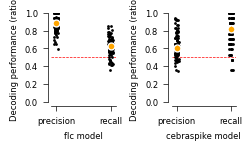

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.5))
ax[0] = plotutils.plot(ax[0], flc_results["metric_data"])
ax[0].set_xlabel("flc model")
ax[1] = plotutils.plot(ax[1], cs_results["metric_data"])
ax[1].set_xlabel("cebraspike model")

plt.tight_layout()

# save
utils.savefig(
    "figures/1_sorting_quality/cebraspike/assets/fig5D_decoding_performance.svg"
)